### DACON_ 음악장르분류: optuna

* 기본데이터로 다양한 모델을 적합시키고, 성능 상위 3개 모델을 optuna로 튜닝후 합치기
* 타겟이 불균형하여 smote-tomek을 적용해봤지만 성능이 더 악화되 그냥 적용안했음

In [1]:
#base
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from collections import Counter

#encoding
from sklearn.preprocessing import LabelEncoder

#scaling
from sklearn.preprocessing import StandardScaler

#sampling
from imblearn.combine import SMOTETomek

#module
from sklearn.model_selection import StratifiedKFold , KFold, train_test_split, cross_val_score, cross_validate

#scoring
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score 

#data_path
test_path = "C:/Users/hyo/Downloads/music_data/test.csv"
train_path = "C:/Users/hyo/Downloads/music_data/train.csv"

#ensemble
from sklearn.ensemble import VotingClassifier

In [2]:
data = pd.read_csv(train_path).drop(columns = ["ID"]) 
test = pd.read_csv(test_path).drop(columns = ["ID"])

In [3]:
#encoding
le=LabelEncoder()
le.fit(data["genre"])
data["genre"]=le.transform(data["genre"])

In [4]:
#scaling
y = data["genre"]

train_x = data.drop(columns='genre')

col_names = list(train_x.columns)

s_scaler = StandardScaler()
x_scaled = s_scaler.fit_transform(train_x)
tet_x_scaled = s_scaler.fit_transform(test)

In [5]:
x = pd.DataFrame(x_scaled, columns=col_names) 
tet_x = pd.DataFrame(tet_x_scaled, columns=col_names) 

### modeling & optuna

In [19]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,learning_curve,cross_val_predict

In [20]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Text(0.5, 0, 'Mean f1score')

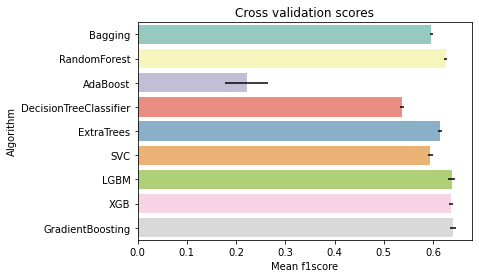

In [22]:
random_state=42
name_classifiers=[("Bagging", BaggingClassifier(random_state=random_state)),\
                  ("RandomForest", RandomForestClassifier(random_state=random_state)),\
                  ("AdaBoost", AdaBoostClassifier(random_state=random_state)),\
                  ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=random_state)),\
                  ("ExtraTrees",ExtraTreesClassifier(random_state=random_state)),\
                  ("SVC", SVC(random_state=random_state)),\
                  ("LGBM",LGBMClassifier(random_state=random_state)),\
                  ("XGB",XGBClassifier(random_state=random_state)),\
                  ("GradientBoosting",GradientBoostingClassifier(random_state=random_state))]
modelname=[]
scores=[]
f1_mean=[]
f1_std=[]
i=0
for name,model in name_classifiers:
    #print(name,model)
    modelname.append(name)
    scores.append(cross_val_score(model, x, y, scoring="f1_macro",verbose=0,n_jobs=4,cv=skf))
    f1_mean.append(scores[i].mean())
    f1_std.append(scores[i].std())

    i+=1
cv_res=pd.DataFrame({"Algorithm":modelname,"CV_mean":f1_mean,"CV_std":f1_std})
g=sns.barplot(data=cv_res, orient='h', y="Algorithm", x="CV_mean",palette="Set3",**{"xerr":f1_std})
g.set_title("Cross validation scores")
g.set_ylabel("Algorithm")
g.set_xlabel("Mean f1score")

In [13]:
# optuna 
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from sklearn.metrics import log_loss

In [42]:
#lgbm
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

def LGBM_objective(trial):
    max_depth = trial.suggest_int('max_depth', 1, 15)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    learning_rate = trial.suggest_float("learning_rate", 4e-2, 1e-1) # default=0.1, range=[0,1]
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.2, 0.9) # feature_fraction, default=1
    subsample = trial.suggest_float("subsample", 0.2, 0.9) # bagging_fraction, default=1, range=[0,1]
    min_child_samples = trial.suggest_int("min_child_samples", 20, 30) # min_data_in_leaf, default=20
    min_child_weight = trial.suggest_float('min_child_weight', 1, 20)

    model = LGBMClassifier(max_depth = max_depth, n_estimators = n_estimators, learning_rate = learning_rate,
                           colsample_bytree = colsample_bytree, subsample = subsample, 
                           min_child_weight= min_child_weight, min_child_samples = min_child_samples, 
                           n_jobs=4,random_state=42)
    score = [] 
    cv_scores = []
    for train_index, test_index in skf.split(x, y):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(x_train, y_train)
        y_pred = model.predict_proba(x_test)
        score = roc_auc_score(y_test, y_pred, multi_class='ovr', average='macro')      
        cv_scores.append(score)
        
    return np.mean(cv_scores)

lgbm_roc_study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
lgbm_roc_study.optimize(LGBM_objective, n_trials=80)

lgbm_roc_best = lgbm_roc_study.best_trial
lgbm_roc_best_params = lgbm_roc_best.params
print('score: {0}, params: {1}'.format(lgbm_roc_best.value, lgbm_roc_best_params))

[I 2023-01-30 09:16:41,404] A new study created in memory with name: no-name-624de4d0-2212-4c7d-ab54-b93a190fd580
[I 2023-01-30 09:17:48,954] Trial 0 finished with value: 0.9451739772128485 and parameters: {'max_depth': 6, 'n_estimators': 956, 'learning_rate': 0.08391963650868431, 'colsample_bytree': 0.6190609389379256, 'subsample': 0.3092130483097056, 'min_child_samples': 21, 'min_child_weight': 2.1035886311957896}. Best is trial 0 with value: 0.9451739772128485.
[I 2023-01-30 09:18:46,898] Trial 1 finished with value: 0.9130381086364912 and parameters: {'max_depth': 13, 'n_estimators': 641, 'learning_rate': 0.08248435466776274, 'colsample_bytree': 0.21440914600706173, 'subsample': 0.8789368965133959, 'min_child_samples': 29, 'min_child_weight': 5.034443102887247}. Best is trial 0 with value: 0.9451739772128485.
[I 2023-01-30 09:18:59,061] Trial 2 finished with value: 0.9554789263106664 and parameters: {'max_depth': 3, 'n_estimators': 265, 'learning_rate': 0.058254534577572264, 'colsa

score: 0.9559793925932432, params: {'max_depth': 3, 'n_estimators': 198, 'learning_rate': 0.09135994489595964, 'colsample_bytree': 0.5907172908133997, 'subsample': 0.5479761302974681, 'min_child_samples': 20, 'min_child_weight': 3.787616293272679}


In [11]:
#rf
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

def RF_objective(trial):
    max_depth = trial.suggest_int('max_depth', 1, 15)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 1000)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    model = RandomForestClassifier(max_depth = max_depth, max_leaf_nodes = max_leaf_nodes,
                                   n_estimators = n_estimators, n_jobs=4, random_state=42)
    score = [] 
    cv_scores = []
    for train_index, test_index in skf.split(x, y):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(x_train, y_train)
        y_pred = model.predict_proba(x_test)
        score = roc_auc_score(y_test, y_pred, multi_class='ovr', average='macro')
        cv_scores.append(score)
        
    return np.mean(cv_scores)

rf_roc_study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
rf_roc_study.optimize(RF_objective, n_trials=100)

rf_roc_best = rf_roc_study.best_trial
rf_roc_best_params = rf_roc_best.params
print('score: {0}, params: {1}'.format(rf_roc_best.value, rf_roc_best_params))

[I 2023-01-30 04:13:15,300] A new study created in memory with name: no-name-d8dc89d2-abc2-4a3f-af78-acabc3129ba0
[I 2023-01-30 04:14:32,237] Trial 0 finished with value: 0.9414069869929933 and parameters: {'max_depth': 6, 'max_leaf_nodes': 951, 'n_estimators': 759}. Best is trial 0 with value: 0.9414069869929933.
[I 2023-01-30 04:15:10,424] Trial 1 finished with value: 0.9483948503135126 and parameters: {'max_depth': 9, 'max_leaf_nodes': 157, 'n_estimators': 240}. Best is trial 1 with value: 0.9483948503135126.
[I 2023-01-30 04:15:37,721] Trial 2 finished with value: 0.8570268673977245 and parameters: {'max_depth': 1, 'max_leaf_nodes': 867, 'n_estimators': 641}. Best is trial 1 with value: 0.9483948503135126.
[I 2023-01-30 04:17:23,138] Trial 3 finished with value: 0.9336963309955336 and parameters: {'max_depth': 11, 'max_leaf_nodes': 22, 'n_estimators': 973}. Best is trial 1 with value: 0.9483948503135126.
[I 2023-01-30 04:18:11,109] Trial 4 finished with value: 0.9502391869923034 an

KeyboardInterrupt: 

In [14]:
#xgb
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

def XGB_objective(trial):
    max_depth = trial.suggest_int('max_depth', 1, 15)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    learning_rate = trial.suggest_float("learning_rate", 4e-2, 1e-1) # default=0.1, range=[0,1]
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.2, 0.9) # feature_fraction, default=1
    subsample = trial.suggest_float("subsample", 0.2, 0.9) # bagging_fraction, default=1, range=[0,1]
    min_child_weight = trial.suggest_float('min_child_weight', 1, 20)

    model = XGBClassifier(max_depth = max_depth, n_estimators = n_estimators, learning_rate = learning_rate,
                          colsample_bytree = colsample_bytree, subsample = subsample, min_child_weight= min_child_weight,
                          n_jobs=4,random_state=42)
    score = [] 
    cv_scores = []
    for train_index, test_index in skf.split(x, y):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(x_train, y_train)
        y_pred = model.predict_proba(x_test)
        score = roc_auc_score(y_test, y_pred, multi_class='ovr', average='macro')      
        cv_scores.append(score)
        
    return np.mean(cv_scores)

xgb_roc_study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
xgb_roc_study.optimize(XGB_objective, n_trials=100)

xgb_roc_best = xgb_roc_study.best_trial
xgb_roc_best_params = xgb_roc_best.params
print('score: {0}, params: {1}'.format(xgb_roc_best.value, xgb_roc_best_params))

[I 2023-01-30 06:45:13,424] A new study created in memory with name: no-name-e15c060b-f729-4114-b9e2-aa39c9bc3ced
[I 2023-01-30 07:02:04,474] Trial 0 finished with value: 0.9460143260723387 and parameters: {'max_depth': 6, 'n_estimators': 956, 'learning_rate': 0.08391963650868431, 'colsample_bytree': 0.6190609389379256, 'subsample': 0.3092130483097056, 'min_child_weight': 3.96389588638785}. Best is trial 0 with value: 0.9460143260723387.
[I 2023-01-30 07:07:24,781] Trial 1 finished with value: 0.9505392217332979 and parameters: {'max_depth': 1, 'n_estimators': 880, 'learning_rate': 0.07606690070459253, 'colsample_bytree': 0.6956508044572318, 'subsample': 0.21440914600706173, 'min_child_weight': 19.428287191077892}. Best is trial 1 with value: 0.9505392217332979.
[I 2023-01-30 07:13:56,751] Trial 2 finished with value: 0.9513622239754373 and parameters: {'max_depth': 13, 'n_estimators': 291, 'learning_rate': 0.05090949803242604, 'colsample_bytree': 0.3283831568974037, 'subsample': 0.412

KeyboardInterrupt: 

In [17]:
lgbm_roc_best_params = {'max_depth': 3, 'n_estimators': 198, 'learning_rate': 0.09135994489595964, 'colsample_bytree': 0.5907172908133997, 'subsample': 0.5479761302974681, 'min_child_samples': 20, 'min_child_weight': 3.787616293272679}

In [18]:
rf_roc_best_params = {'max_depth': 14, 'max_leaf_nodes': 804, 'n_estimators': 735}

In [19]:
xgb_roc_best_params = {'max_depth': 2, 'n_estimators': 720, 'learning_rate': 0.05925101071718902, 'colsample_bytree': 0.8948914655705359, 'subsample': 0.545181348705896, 'min_child_weight': 8.144432018260666}

In [20]:
LGBMC = LGBMClassifier()
lgb_best_model = LGBMClassifier(**lgbm_roc_best_params, n_jobs= 4, random_state=42)

In [21]:
RFC = RandomForestClassifier()
rf_best_model = RandomForestClassifier(**rf_roc_best_params, n_jobs= 4, random_state=42)

In [22]:
XGBC = XGBClassifier()
xgb_best_model = XGBClassifier(**xgb_roc_best_params, n_jobs= 4, random_state=42)

In [28]:
model_all=VotingClassifier([("LGBMC",lgb_best_model),("RFC",rf_best_model),("XGBC",xgb_best_model)],voting='soft',n_jobs=4)
model_all.fit(x, y)

VotingClassifier(estimators=[('LGBMC',
                              LGBMClassifier(colsample_bytree=0.5907172908133997,
                                             learning_rate=0.09135994489595964,
                                             max_depth=3,
                                             min_child_weight=3.787616293272679,
                                             n_estimators=198, n_jobs=4,
                                             random_state=42,
                                             subsample=0.5479761302974681)),
                             ('RFC',
                              RandomForestClassifier(max_depth=14,
                                                     max_leaf_nodes=804,
                                                     n_estimators=735, n_jobs=4,
                                                     random_state=42)),
                             (...
                                            interaction_constraints=None,
                                            learning_rate=0.05925101071718902,
                                            max_bin=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=2,
                                            max_leaves=None,
                                            min_child_weight=8.144432018260666,
                                            missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=720, n_jobs=4,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=42,
                                            reg_alpha=None, reg_lambda=None, ...))],
                 n_jobs=4, voting='soft')

In [ ]:
#각 모델별 성능

In [44]:
# LGBM
a_clf = [] 
f1_clf = [] 

for train_index, test_index in skf.split(x, y):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
   
    #smote-tomek
    #smt = SMOTETomek(random_state=42)
    #smt_x, smt_y = smt.fit_resample(x_train, y_train)
 
    #clf    
    
    lgb_roc_model.fit(x_train, y_train) ##
    y_test = y_test.to_numpy()
    y_pred = lgb_roc_model.predict(x_test)
   
    #score
    accuracy = accuracy_score(y_test, y_pred)
    a_clf.append(accuracy)
    
    f1 = f1_score(y_test, y_pred, average='micro')
    f1_clf.append(f1)  

NameError: name 'lgb_roc_model' is not defined

In [48]:
print( round(np.mean(a_clf),5), round(np.mean(f1_clf),5) )

0.68751 0.68751


In [53]:
# RFC
a_clf = [] 
f1_clf = [] 

for train_index, test_index in skf.split(x, y):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
   
    #smote-tomek
    #smt = SMOTETomek(random_state=42)
    #smt_x, smt_y = smt.fit_resample(x_train, y_train)
 
    #clf    
    rf_roc_model.fit(x_train, y_train) 
    y_test = y_test.to_numpy()
    y_pred = rf_roc_model.predict(x_test)
   
    #score
    accuracy = accuracy_score(y_test, y_pred)
    a_clf.append(accuracy)
    
    f1 = f1_score(y_test, y_pred, average='micro')
    f1_clf.append(f1)  

In [54]:
print( round(np.mean(a_clf),5), round(np.mean(f1_clf),5) )

0.65768 0.65768


In [55]:
# XGBC
a_clf = [] 
f1_clf = [] 

for train_index, test_index in skf.split(x, y):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
   
    #smote-tomek
    #smt = SMOTETomek(random_state=42)
    #smt_x, smt_y = smt.fit_resample(x_train, y_train)
 
    #clf    
    xgb_roc_model.fit(x_train, y_train) ##
    y_test = y_test.to_numpy()
    y_pred =  xgb_roc_model.predict(x_test)
   
    #score
    accuracy = accuracy_score(y_test, y_pred)
    a_clf.append(accuracy)
    
    f1 = f1_score(y_test, y_pred, average='micro')
    f1_clf.append(f1)  

In [56]:
print( round(np.mean(a_clf),5), round(np.mean(f1_clf),5) )

0.67403 0.67403


In [36]:
#real
preds = model_all.predict(tet_x) 

In [37]:
len(preds)

16922

In [38]:
submit = pd.read_csv("C:/Users/hyo/Downloads/music_data/sample_submission.csv")

In [39]:
submit['genre'] = le.inverse_transform(preds)

In [40]:
submit['genre']

0                 Hiphop
1        Underground Rap
2                    Emo
3              techhouse
4                    Pop
              ...       
16917          techhouse
16918             Hiphop
16919          hardstyle
16920          psytrance
16921    Underground Rap
Name: genre, Length: 16922, dtype: object

In [41]:
submit.to_csv('./ens_2.csv', index=False)

* 아래는 번외로 gradient boosting 튜닝 한거 코드 만들어 놓은거
* 근데 시간이 제일 오래걸리는 모델이라 못돌림ㅜㅜ

In [ ]:
'''
# 합친거 성능 비교
a_clf = [] 
f1_clf = [] 

for train_index, test_index in skf.split(x, y):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
   
    #smote-tomek
    #smt = SMOTETomek(random_state=42)
    #smt_x, smt_y = smt.fit_resample(x_train, y_train)
 
    #clf    
    #model=VotingClassifier([("LGBMC",lgb_best_model),("RFC",rf_best_model),("XGBC",xgb_best_model)],voting='soft',n_jobs=4)
    model.fit(x_train, y_train)
    y_test = y_test.to_numpy()
    y_pred = model.predict(x_test)
   
    #score
    accuracy = accuracy_score(y_test, y_pred)
    a_clf.append(accuracy)
    
    f1 = f1_score(y_test, y_pred, average='micro')
    f1_clf.append(f1)  
'''
#print( round(np.mean(a_clf),5), round(np.mean(f1_clf),5) )

In [ ]:
'''
ens_0
{'max_depth': 13, 'n_estimators': 291, 'learning_rate': 0.05090949803242604, 
 'colsample_bytree': 0.3283831568974037, 'subsample': 0.4129695700716764, 'min_child_weight': 10.97037220101252}

{'max_depth': 9, 'max_leaf_nodes': 157, 'n_estimators': 240}

{'max_depth': 13, 'n_estimators': 291, 'learning_rate': 0.05090949803242604, 'colsample_bytree': 0.3283831568974037, 
 'subsample': 0.4129695700716764, 'min_child_weight': 10.97037220101252}
'''

#model=VotingClassifier([("LGBMC",lgb_best_model),("RFC",rf_best_model),("XGBC",xgb_best_model)],voting='soft',n_jobs=4)
#model.fit(x_train, y_train)

In [ ]:
'''
#grad_b
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

def GRAD_objective(trial):
    max_depth = trial.suggest_int('max_depth', 1, 15)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    learning_rate = trial.suggest_float("learning_rate", 4e-2, 1e-1) # default=0.1, range=[0,1]
    #colsample_bytree = trial.suggest_float("colsample_bytree", 0.2, 0.9) # feature_fraction, default=1
    subsample = trial.suggest_float("subsample", 0.2, 0.9) # bagging_fraction, default=1, range=[0,1]
    #min_child_weight = trial.suggest_float('min_child_weight', 1, 20)

    model = GradientBoostingClassifier(max_depth = max_depth, n_estimators = n_estimators, 
                                       learning_rate = learning_rate, subsample = subsample, 
                                       #min_child_weight= min_child_weight, colsample_bytree = colsample_bytree, n_jobs=4,
                                       random_state=42)
    score = [] 
    cv_scores = []
    for train_index, test_index in skf.split(x, y):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(x_train, y_train)
        y_pred = model.predict_proba(x_test)
        score = roc_auc_score(y_test, y_pred, multi_class='ovr', average='macro')      
        cv_scores.append(score)
        
    return np.mean(cv_scores)

grad_roc_study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
grad_roc_study.optimize(GRAD_objective, n_trials=3)

grad_roc_best = grad_roc_study.best_trial
grad_roc_best_params = grad_roc_best.params
print('score: {0}, params: {1}'.format(grad_roc_best.value, grad_roc_best_params))
'''

In [ ]:
#GBC = GradientBoostingClassifier()
#grad_roc_model = GradientBoostingClassifier(**grad_roc_best_params, n_jobs= 4, random_state=42)

### 느낀점
* 시간이 부족해서 파라미터 튜닝을 제대로 못한게 너무 아쉬웠다ㅜㅜ
* 시간이 없다면 케이폴드는 중요한 곳에서만 쓰자,,
* 툴 아는것은 중요하다
* 기술적인 것에 치우쳐 목적을 잊지 말자